100% (10999 of 10999) |##################| Elapsed Time: 0:01:40 Time:  0:01:40


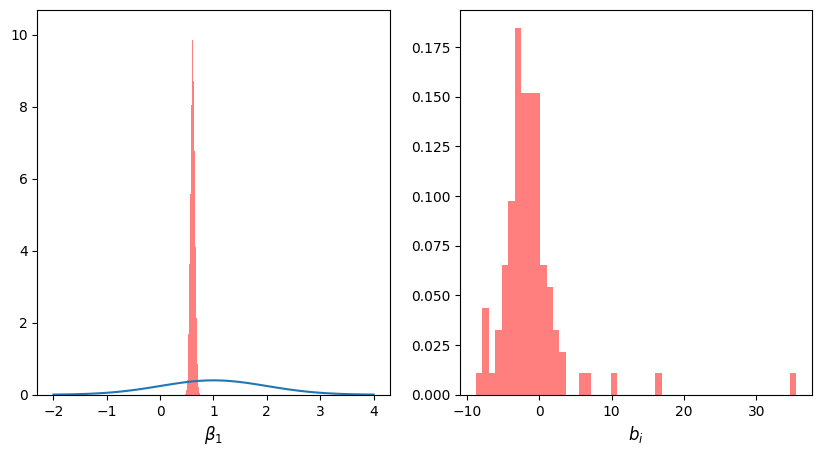

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
from progressbar import progressbar

# Panel data model
def panel(y, x, w, s, beta0, B0, alpha0, delta0, nu0, D0):
    # Initialization
    n, T = y.shape
    sample = {'beta': np.zeros((s, x.shape[1])), 'b': np.zeros((s, w.shape[1], n)), 'h': np.zeros((s, 1))}
    sample['h'][0] = alpha0 / delta0
    alpha1 = alpha0 + n * T
    nu1 = nu0 + w.shape[1]
    
    # Sampling
    for i in progressbar(range(1, s)):
        delta1 = delta0
        for j in range(n):
            err = y[j, :].reshape(-1, 1) - x[:, :, j] @ sample['beta'][i - 1, :].reshape(-1, 1) - w[:, :, j] @ sample['b'][i - 1, :, j].reshape(-1, 1)
            delta1 += err.T @ err
        sample['h'][i] = stats.gamma.rvs(alpha1 / 2, size=1, scale=2 / delta1)

        D1 = np.linalg.inv(D0)
        for j in range(n):
            D1 += sample['b'][i - 1, :, j].reshape(-1, 1) @ sample['b'][i - 1, :, j].reshape(1, -1)
        D1 = np.linalg.inv(D1)
        inv_D = stats.wishart.rvs(df = nu1, size=1, scale=D1)

        for j in range(n):
            D1j = np.linalg.inv(inv_D + sample['h'][i] * w[:, :, j].T @ w[:, :, j])
            b1j = D1j @ (sample['h'][i] * w[:, :, j].T @ (y[j, :].reshape(-1, 1) - x[:, :, j] @ sample['beta'][i - 1, :].reshape(-1, 1)))
            sample['b'][i, :, j] = stats.multivariate_normal.rvs(size=1, mean=b1j.ravel(), cov=D1j)

        B1 = np.linalg.inv(B0)
        beta1 = np.linalg.inv(B0) @ beta0.reshape(-1, 1)
        for j in range(n):
            B1j = w[:, :, j] @ w[:, :, j].T / inv_D + np.eye(T) / sample['h'][i]
            B1 += x[:, :, j].T @ np.linalg.inv(B1j) @ x[:, :, j]
            beta1 += x[:, :, j].T @ np.linalg.inv(B1j) @ y[j, :].reshape(-1, 1)
        B1 = np.linalg.inv(B1)
        beta1 = B1 @ beta1
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)
        
    return sample

# Import data
with open("inflation.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=float)
n = data.shape[0]
y = data[:, 0:4]
x = np.zeros((4, 2, n))
for i in range(n):
    x[:, 0, i] = 1
    x[:, 1, i] = data[i, 4:8].T
w = np.ones((4, 1, n))

# Prior and posterior
beta0 = np.array([0, 1])
B0 = np.identity(2)
alpha0 = 5
delta0 = 5
nu0 = 5
D0 = np.identity(1)
s = 11000
burn = 1000
sample = panel(y, x, w, s, beta0, B0, alpha0, delta0, nu0, D0)
sample['beta'] = sample['beta'][burn:s, :]
sample['b'] = sample['b'][burn:s, :, :]
sample['h'] = sample['h'][burn:s]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
b1 = np.linspace(-2, 4, 100)
ax1.plot(b1, stats.norm.pdf(b1, loc=1, scale=1))
ax1.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$\beta_1$', fontsize=12)
ax2.hist(np.mean(sample['b'], axis=0).reshape(-1, 1), bins=50, density=True, color="red", alpha=0.5)
ax2.set_xlabel(r'$b_i$', fontsize=12)
plt.show()